In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay 
import requests
from bs4 import BeautifulSoup
from datetime import date, timedelta 
import time

#Alpha_Vantage is a stock data provider.  This library makes api calls much easier 
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries  

## First, we'll read in the data output by the scraper and do any cleaning that didn't survive the "to_csv" part of the last notebook.  

In [2]:
df = pd.read_csv('AllHoldings.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390168 entries, 0 to 390167
Data columns (total 12 columns):
manager            390168 non-null object
filing_date        390168 non-null object
report_date        390168 non-null object
sh_name            390168 non-null object
sh_class           390168 non-null object
cusip              390168 non-null object
val1000            390168 non-null int64
share_count        390168 non-null int64
share_or_prin      390168 non-null object
discretion         390168 non-null object
sole_vote_amt      390168 non-null int64
shared_vote_amt    390168 non-null int64
dtypes: int64(4), object(8)
memory usage: 35.7+ MB


In [4]:
df['report_date'] = pd.to_datetime(df.report_date)

In [5]:
df['filing_date'] = pd.to_datetime(df.filing_date)

## The next step is to return only the top 20 holdings, aggregated by date and Cusip/Share.   

In [6]:
# Sums up the holdings by date/cusip and returns a flattened dataframe with report_date as the index
summed_df = df.groupby(['report_date', 'cusip', 'sh_name'])['report_date', 'cusip', 'sh_name', 'val1000'].sum().reset_index()
summed_df.set_index('report_date')

,cusip,sh_name,val1000
report_date,,,
2013-06-30,000360206,AAON INC,1179
2013-06-30,000361105,AAR CORP,2039
2013-06-30,000375204,ABB LTD,4802
2013-06-30,00081T108,ACCO BRANDS CORP,65
2013-06-30,000957100,ABM INDS INC,1731
2013-06-30,00101J106,THE ADT CORPORATION,12867
2013-06-30,001031103,AEP INDS INC,536
2013-06-30,00104Q107,AFC ENTERPRISES INC,4421
2013-06-30,001055102,AFLAC INC,75176


In [7]:
#Sets variables that will be used to loop through each report_date and select the top 20 by notional value
looper = summed_df.report_date.value_counts().index
top_df = pd.DataFrame(columns=['report_date', 'cusip', 'sh_name', 'val1000'])

In [8]:
for x in looper:
    top_df = top_df.append(summed_df[(summed_df.report_date == x)].nlargest(20, 'val1000'))

In [9]:
top_df = top_df.sort_values(['report_date', 'val1000'], ascending=[False, False]).reset_index().drop('index', axis=1)

## Now, the goal is to pull back stock tickers for all of the stocks that appear in our 420 row dataframe.  

#### This is a somewhat complicated task as stocks can undergo certain changes (which is why CUSIPS are often used as an identifier.

#### Fidelity seems to be the only free source of a cusip lookup, so I will first scrape there.  If there aren't too many NaNs after scraping Fidelity, I'll just figure out the rest of the tickers by hand.  If there are a lot, then I'll try some other automated solution.

In [10]:
# creates a list of unique cusips.
cusips = list(top_df.cusip.unique())

In [11]:
cusips[:5]

['037833100', '78462F103', '949746101', '060505104', '500754106']

In [21]:
url1 = 'https://quotes.fidelity.com/mmnet/SymLookup.phtml?reqforlookup=REQUESTFORLOOKUP&productid=mmnet&isLoggedIn=mmnet&rows=50&for=stock&by=cusip&criteria='
url2 = '&submit=Search'
ticker = []

for cusip in cusips:
    response = requests.get(url1+cusip+url2)
    time.sleep(1)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        ticker.append(soup.find('td', {'align':'center'}).get_text())
    except:
        ticker.append(cusip+'Not Found')

In [12]:
#cusip_ticker = pd.DataFrame({'cusip':cusips, 'tickers':ticker})
cusip_ticker = pd.read_csv('cusip_ticker.csv')  
cusip_ticker.columns=['d', 'cusip', 'ticker']
cusip_ticker.drop('d', axis=1)
cusip_ticker.head()

,d,cusip,ticker
0,0,949746101,WFC
1,1,500754106,KHC
2,2,191216100,KO
3,3,459200101,IBM
4,4,025816109,AXP


In [13]:
cusip_ticker[cusip_ticker.ticker.str.contains('Not')]
cusip_ticker.iloc[7,2] = 'SPY' 
cusip_ticker.iloc[10,2] = 'SPY' 
cusip_ticker.iloc[14,2] = 'VRX' #Company acquired by Bausch and Lomb 
cusip_ticker.iloc[20,2] = 'AAPL' #Looks like a miskey by the 13F filer
cusip_ticker.iloc[21,2] = 'DTV' #Company acquired by AT&T
cusip_ticker.iloc[29,2] = 'AGN' #Company acquired
cusip_ticker.iloc[33,2] = 'EMC' #Company acquired
cusip_ticker.iloc[46,2] = 'QQQ' #Fidelity tool not able to handle ETFs
cusip_ticker.iloc[48,2] = 'PCLN' #Company acquired by Bausch and Lomb 
cusip_ticker.iloc[56,2] = 'FRX' #Company acquired 
cusip_ticker.iloc[57,2] = 'MDT' #Company acquired 
cusip_ticker.iloc[58,2] = 'DWDP' #Company acquired 
cusip_ticker.iloc[60,2] = 'DELL' #Company went private 
cusip_ticker.iloc[61,2] = 'YHOO' #Company acquired 
cusip_ticker.iloc[64,2] = 'FDML' #Company went private 


In [14]:
API = 'INAPOMK44YJBVQY9'
ts = TimeSeries(key='API', output_format='pandas', indexing_type='date')

In [ ]:
alpha_data, alpha_meta_data = ts.get_daily_adjusted(symbol='WFC', outputsize='full')

In [ ]:
alpha_data.head()

In [ ]:
alpha_meta_data

## The above "alpha_data" dataframe came from the alphavantage API.  Virtually all of the cusips belonging to the tickers above (cusips not found) were missing from AV.  So, I instead sourced the data from another source that has unadjusted close prices only.  Given the infrequency of my strategy's trading, the likelihood of corporate actions having a significant effect is low.

In [15]:
top_df = pd.merge(top_df, cusip_ticker, how='left', on='cusip').drop('d', axis=1)

##  The dates I have are the dates when the investors held a position.  Their reports are filed 43-45 days after this date.  To make my life easier, I ignored the "filing_date" column from my 13F scraper and just use the next business day 44 days after the "report_date" col. 

In [16]:
top_df['buy_date'] = top_df['report_date'].apply(lambda x: x +  timedelta(days=44) + BDay(1))

In [17]:
top_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 6 columns):
report_date    420 non-null datetime64[ns]
cusip          420 non-null object
sh_name        420 non-null object
val1000        420 non-null object
ticker         420 non-null object
buy_date       420 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 23.0+ KB


In [18]:
prices = pd.read_csv('Yahoo_Prices.csv')
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67741 entries, 0 to 67740
Data columns (total 3 columns):
Date         67741 non-null object
Adj Close    67741 non-null float64
ticker       67741 non-null object
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [19]:
# prices = prices.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1 )
prices.Date = pd.to_datetime(prices.Date)
prices.Date = prices.Date.apply(lambda x: x.date())

In [20]:
buy_prices = pd.DataFrame(columns=['Date', 'Adj Close', 'ticker'])

In [21]:
x = top_df['buy_date'].dt.date.unique()
for z in x:
    buy_prices = buy_prices.append(prices[prices.Date==z])

In [22]:
buy_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1071 entries, 30 to 67709
Data columns (total 3 columns):
Date         1071 non-null object
Adj Close    1071 non-null float64
ticker       1071 non-null object
dtypes: float64(1), object(2)
memory usage: 33.5+ KB


In [23]:
buy_prices.head()

,Date,Adj Close,ticker
30,2018-08-14,78.309998,XOM
1349,2018-08-14,90.849998,WMT
2668,2018-08-14,58.070000,WFC
3987,2018-08-14,41.930000,VWO
5310,2018-08-14,53.169998,USB


In [24]:
# buy_prices.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)
buy_prices.reset_index(inplace=True)

In [25]:
buy_prices = buy_prices.drop('index', axis=1)
buy_prices.head()

,Date,Adj Close,ticker
0,2018-08-14,78.309998,XOM
1,2018-08-14,90.849998,WMT
2,2018-08-14,58.070000,WFC
3,2018-08-14,41.930000,VWO
4,2018-08-14,53.169998,USB


In [26]:
buy_prices.Date = pd.to_datetime(buy_prices.Date)

In [27]:
top_df = pd.merge(top_df, buy_prices, how='left', left_on=['ticker', 'buy_date'], right_on=['ticker', 'Date'])

In [28]:
top_df.sort_values(['buy_date', 'ticker'], inplace = True, ascending=True)
top_df.reset_index(drop= True, inplace = True)
top_df['sell_date'] = top_df.buy_date.shift(periods = -20)
top_df.drop('Date', axis=1, inplace=True)

In [29]:
top_df = pd.merge(top_df, buy_prices, how='left', left_on=['ticker', 'sell_date'], right_on=['ticker', 'Date'])

In [30]:
top_df[top_df.ticker=='QQQ']

,report_date,cusip,sh_name,val1000,ticker,buy_date,Adj Close_x,sell_date,Date,Adj Close_y
299,2016-12-31,73935A104,POWERSHARES QQQ TRUST,3755022,QQQ,2017-02-14,126.891113,2017-05-15,2017-05-15,137.552612
319,2017-03-31,73935A104,POWERSHARES QQQ TRUST,4444607,QQQ,2017-05-15,137.552612,2017-08-14,2017-08-14,142.778214
339,2017-06-30,73935A104,POWERSHARES QQQ TRUST,4330193,QQQ,2017-08-14,142.778214,2017-11-14,2017-11-14,152.416031
378,2017-12-31,73935A104,POWERSHARES QQQ TRUST,5140654,QQQ,2018-02-14,162.069611,2018-05-15,2018-05-15,167.511459
399,2018-03-31,73935A104,POWERSHARES QQQ TRUST,9494668,QQQ,2018-05-15,167.511459,2018-08-14,2018-08-14,181.449997
418,2018-06-30,46090E103,INVESCO QQQ TR,8792866,QQQ,2018-08-14,181.449997,NaT,NaT,NaN


In [31]:
top_df.rename(columns={'Adj Close_x': 'buy_price', 'Adj Close_y': 'sell_price'}, inplace=True)
top_df.drop('Date', axis=1, inplace=True)

In [32]:
top_df[top_df.ticker=='AAPL'].head(7)

,report_date,cusip,sh_name,val1000,ticker,buy_date,buy_price,sell_date,sell_price
20,2013-09-30,037833100,APPLE INC,2753258,AAPL,2013-11-14,69.157845,2014-02-14,71.656990
40,2013-12-31,037833100,APPLE INC,6451807,AAPL,2014-02-14,71.656990,2014-05-15,77.995438
60,2014-03-31,037833100,APPLE INC,7460756,AAPL,2014-05-15,77.995438,2014-08-14,90.854004
80,2014-06-30,037833100,APPLE INC,9073138,AAPL,2014-08-14,90.854004,2014-11-14,106.858391
100,2014-09-30,037833100,APPLE INC,9466057,AAPL,2014-11-14,106.858391,2014-11-14,106.858391
122,2014-12-31,137833100,APPLE INC,5823743,AAPL,2015-02-16,120.105263,2015-02-16,120.105263
123,2014-12-31,037833100,APPLE INC,4620136,AAPL,2015-02-16,120.105263,2015-05-15,121.493835


In [33]:
portfolio = top_df[['ticker', 'sh_name', 'buy_date', 'buy_price', 'sell_date', 'sell_price']]

In [34]:
portfolio.head()

,ticker,sh_name,buy_date,buy_price,sell_date,sell_price
0,AXP,AMERICAN EXPRESS CO,2013-08-14,70.487648,2013-11-14,76.301682
1,COP,CONOCOPHILLIPS,2013-08-14,57.361557,2013-11-14,63.558880
2,CP,CANADIAN PAC RY LTD,2013-08-14,115.452370,2013-11-14,140.971481
3,CVI,CVR ENERGY INC,2013-08-14,28.293880,2013-11-14,24.337425
4,DELL,DELL INC,2013-08-14,13.720000,2013-11-14,13.840000


In [36]:
portfolio['shares_bought'] = 1
portfolio['notional_bought'] = 1
portfolio['notional_sold'] = 1
sum_not_sold = 10000000

In [37]:
looper = portfolio.buy_date.value_counts().index.sort_values()
looper

DatetimeIndex(['2013-08-14', '2013-11-14', '2014-02-14', '2014-05-15',
               '2014-08-14', '2014-11-14', '2015-02-16', '2015-05-15',
               '2015-08-14', '2015-11-16', '2016-02-15', '2016-05-16',
               '2016-08-15', '2016-11-14', '2017-02-14', '2017-05-15',
               '2017-08-14', '2017-11-14', '2018-02-14', '2018-05-15',
               '2018-08-14'],
              dtype='datetime64[ns]', freq=None)

In [38]:
portfolio.loc[portfolio.buy_date=='2013-08-14','shares_bought'] = sum_not_sold/20/portfolio['buy_price']

In [39]:
portfolio.loc[portfolio.buy_date=='2013-08-14','notional_bought'] = portfolio['shares_bought']*portfolio['buy_price']

In [40]:
portfolio.loc[portfolio.buy_date=='2013-08-14','notional_sold'] = portfolio['shares_bought']*portfolio['sell_price']

In [41]:
portfolio.head(22)

,ticker,sh_name,buy_date,buy_price,sell_date,sell_price,shares_bought,notional_bought,notional_sold
0,AXP,AMERICAN EXPRESS CO,2013-08-14,70.487648,2013-11-14,76.301682,7093.441393,500000.0,541241.509434
1,COP,CONOCOPHILLIPS,2013-08-14,57.361557,2013-11-14,63.558880,8716.639264,500000.0,554019.828995
2,CP,CANADIAN PAC RY LTD,2013-08-14,115.452370,2013-11-14,140.971481,4330.790264,500000.0,610517.917475
3,CVI,CVR ENERGY INC,2013-08-14,28.293880,2013-11-14,24.337425,17671.666099,500000.0,430082.848305
4,DELL,DELL INC,2013-08-14,13.720000,2013-11-14,13.840000,36443.148688,500000.0,504373.177843
5,DTV,DIRECTV,2013-08-14,61.410000,2013-11-14,64.350000,8141.996418,500000.0,523937.469468
6,DVA,DAVITA HEALTHCARE PARTNERS I,2013-08-14,57.299999,2013-11-14,58.689999,8726.003643,500000.0,512129.145063
7,EEM,ISHARES TR,2013-08-14,36.305775,2013-11-14,37.537094,13771.913697,500000.0,516957.619001
8,IBM,INTERNATIONAL BUSINESS MACHS,2013-08-14,155.742050,2013-11-14,152.136490,3210.436745,500000.0,488424.577691
9,IEP,ICAHN ENTERPRISES LP,2013-08-14,49.667171,2013-11-14,75.680756,10067.011870,500000.0,761879.068973


In [42]:
sum_not_sold = portfolio.loc[portfolio.buy_date=='2013-08-14'].groupby('buy_date')['notional_sold'].sum()

In [43]:
sum_not_sold = sum_not_sold.values

In [44]:
portfolio.loc[portfolio.buy_date=='2013-11-14']['buy_price']

20     69.157845
21     87.811844
22     76.301682
23    140.971481
24     24.337425
25     64.350000
26     37.537094
27     20.080000
28     31.392313
29    152.136490
30     75.680756
31     34.250286
32     48.938572
33     72.415459
34    162.423294
35     34.283451
36     36.463646
37     37.669060
38     69.430504
39     79.097527
Name: buy_price, dtype: float64

In [45]:
portfolio.loc[portfolio.buy_date=='2013-11-14','shares_bought'] = sum_not_sold/20/portfolio['buy_price']

In [46]:
portfolio.loc[portfolio.buy_date=='2013-11-14','notional_bought'] = portfolio['shares_bought']*portfolio['buy_price']

In [47]:
portfolio.loc[portfolio.buy_date=='2013-11-14','notional_sold'] = portfolio['shares_bought']*portfolio['sell_price']

In [48]:
portfolio.loc[portfolio.buy_date=='2013-11-14']

,ticker,sh_name,buy_date,buy_price,sell_date,sell_price,shares_bought,notional_bought,notional_sold
20,AAPL,APPLE INC,2013-11-14,69.157845,2014-02-14,71.656990,7843.531781,542441.755191,562043.878425
21,APD,AIR PRODS & CHEMS INC,2013-11-14,87.811844,2014-02-14,95.496201,6177.318804,542441.755191,589910.478187
22,AXP,AMERICAN EXPRESS CO,2013-11-14,76.301682,2014-02-14,83.140488,7109.171659,542441.755191,591060.000986
23,CP,CANADIAN PAC RY LTD,2013-11-14,140.971481,2014-02-14,147.010574,3847.882929,542441.755191,565679.478051
24,CVI,CVR ENERGY INC,2013-11-14,24.337425,2014-02-14,24.343891,22288.379119,542441.755191,542585.871851
25,DTV,DIRECTV,2013-11-14,64.350000,2014-02-14,71.890000,8429.553305,542441.755191,606000.587113
26,EEM,ISHARES,2013-11-14,37.537094,2014-02-14,36.231758,14450.819107,542441.755191,523578.580782
27,FDML,FEDERAL MOGUL CORP,2013-11-14,20.080000,2014-02-14,17.180000,27014.031633,542441.755191,464101.063455
28,GM,GENERAL MTRS CO,2013-11-14,31.392313,2014-02-14,29.313080,17279.445296,542441.755191,506513.762311
29,IBM,INTERNATIONAL BUSINESS MACHS,2013-11-14,152.136490,2014-02-14,154.213013,3565.494085,542441.755191,549845.585665


In [49]:
for date in looper:
    portfolio.loc[portfolio.buy_date==pd.to_datetime(date),'shares_bought'] = sum_not_sold/20/portfolio['buy_price']
    portfolio.loc[portfolio.buy_date==pd.to_datetime(date),'notional_bought'] = portfolio['shares_bought']*portfolio['buy_price']
    portfolio.loc[portfolio.buy_date==pd.to_datetime(date),'notional_sold'] = portfolio['shares_bought']*portfolio['sell_price']
    sum_not_sold = portfolio.loc[portfolio.buy_date==pd.to_datetime(date)].groupby('buy_date')['notional_sold'].sum()
    sum_not_sold = sum_not_sold.values

In [51]:
portfolio[portfolio.notional_sold.isna()]

,ticker,sh_name,buy_date,buy_price,sell_date,sell_price,shares_bought,notional_bought,notional_sold
403,AAPL,APPLE INC,2018-08-14,209.750000,NaT,NaN,5471.329148,1.147611e+06,NaN
404,AMZN,AMAZON COM INC,2018-08-14,1919.650024,NaT,NaN,597.823184,1.147611e+06,NaN
405,AXP,AMERICAN EXPRESS CO,2018-08-14,102.180000,NaT,NaN,11231.271176,1.147611e+06,NaN
406,BABA,ALIBABA GROUP HLDG LTD,2018-08-14,172.529999,NaT,NaN,6651.662293,1.147611e+06,NaN
407,BAC,BANK AMER CORP,2018-08-14,30.641878,NaT,NaN,37452.380980,1.147611e+06,NaN
408,BKNG,BOOKING HLDGS INC,2018-08-14,1833.550049,NaT,NaN,625.895808,1.147611e+06,NaN
409,FB,FACEBOOK INC,2018-08-14,181.110001,NaT,NaN,6336.542888,1.147611e+06,NaN
410,GOOGL,ALPHABET INC,2018-08-14,1258.140015,NaT,NaN,912.149105,1.147611e+06,NaN
411,IEP,ICAHN ENTERPRISES LP,2018-08-14,78.790001,NaT,NaN,14565.443257,1.147611e+06,NaN
412,IWM,ISHARES TR,2018-08-14,168.199997,NaT,NaN,6822.897201,1.147611e+06,NaN


In [60]:
strat_results = portfolio.groupby('buy_date')[['notional_bought']].sum()

In [62]:
strat_results

,notional_bought
buy_date,
2013-08-14,1.084884e+07
2013-11-14,1.176972e+07
2014-02-14,1.202527e+07
2014-05-15,1.238548e+07
2014-08-14,1.303272e+07
2014-11-14,1.490342e+07
2015-02-16,1.579807e+07
2015-05-15,1.608431e+07
2015-08-14,1.571249e+07


In [110]:
s_and_p = portfolio.groupby('buy_date').max()

In [111]:
s_and_p.ticker = 'S&P'
s_and_p.sh_name = 'S&P 500 Index' 

In [112]:
s_and_p.columns

Index(['ticker', 'sh_name', 'buy_price', 'sell_date', 'sell_price',
       'shares_bought', 'notional_bought', 'notional_sold'],
      dtype='object')

In [113]:
s_and_p = s_and_p.drop(['buy_price','shares_bought', 'notional_bought', 'notional_sold', 'sell_price'], axis=1)

In [114]:
s_and_p.reset_index(inplace=True)

In [116]:
sp_prices=pd.read_csv('sp_prices.csv')

In [117]:
sp_prices.Date=pd.to_datetime(sp_prices.Date)

In [118]:
sp_prices.head()

,Date,Adj Close,Ticker
0,2013-08-14,1685.390015,S&P
1,2013-08-15,1661.319946,S&P
2,2013-08-16,1655.829956,S&P
3,2013-08-19,1646.060059,S&P
4,2013-08-20,1652.349976,S&P


In [119]:
s_and_p = pd.merge(s_and_p, sp_prices, how='left', left_on=['ticker', 'buy_date'], right_on=['Ticker', 'Date'])

In [121]:
s_and_p.rename(columns={'Adj Close': 'buy_price'}, inplace=True)

In [122]:
s_and_p['sell_price']=s_and_p.buy_price.shift(periods=-1)

In [129]:
s_and_p['shares_bought'] = 1
s_and_p['notional_bought'] = 1
s_and_p['notional_sold'] = 1
sum_not_sold = 10000000

In [130]:
s_and_p.head()

,buy_date,ticker,sh_name,sell_date,Date,buy_price,Ticker,sell_price,shares_bought,notional_bought,notional_sold
0,2013-08-14,S&P,S&P 500 Index,2013-11-14,2013-08-14,1685.390015,S&P,1790.619995,1,1,1
1,2013-11-14,S&P,S&P 500 Index,2014-02-14,2013-11-14,1790.619995,S&P,1838.630005,1,1,1
2,2014-02-14,S&P,S&P 500 Index,2014-05-15,2014-02-14,1838.630005,S&P,1870.849976,1,1,1
3,2014-05-15,S&P,S&P 500 Index,2014-08-14,2014-05-15,1870.849976,S&P,1955.180054,1,1,1
4,2014-08-14,S&P,S&P 500 Index,2014-11-14,2014-08-14,1955.180054,S&P,2039.819946,1,1,1


In [131]:
looper = s_and_p.buy_date.value_counts().index.sort_values()
looper.date

array([datetime.date(2013, 8, 14), datetime.date(2013, 11, 14),
       datetime.date(2014, 2, 14), datetime.date(2014, 5, 15),
       datetime.date(2014, 8, 14), datetime.date(2014, 11, 14),
       datetime.date(2015, 2, 16), datetime.date(2015, 5, 15),
       datetime.date(2015, 8, 14), datetime.date(2015, 11, 16),
       datetime.date(2016, 2, 15), datetime.date(2016, 5, 16),
       datetime.date(2016, 8, 15), datetime.date(2016, 11, 14),
       datetime.date(2017, 2, 14), datetime.date(2017, 5, 15),
       datetime.date(2017, 8, 14), datetime.date(2017, 11, 14),
       datetime.date(2018, 2, 14), datetime.date(2018, 5, 15),
       datetime.date(2018, 8, 14)], dtype=object)

In [132]:
for date in looper:
    s_and_p.loc[s_and_p.buy_date==pd.to_datetime(date),'shares_bought'] = sum_not_sold/s_and_p['buy_price']
    s_and_p.loc[s_and_p.buy_date==pd.to_datetime(date),'notional_bought'] = s_and_p['shares_bought']*s_and_p['buy_price']
    s_and_p.loc[s_and_p.buy_date==pd.to_datetime(date),'notional_sold'] = s_and_p['shares_bought']*s_and_p['sell_price']
    sum_not_sold = s_and_p.loc[s_and_p.buy_date==pd.to_datetime(date)].groupby('buy_date')['notional_sold'].sum()
    sum_not_sold = sum_not_sold.values

In [153]:
s_and_p_results = s_and_p[['buy_date', 'notional_bought']]

In [154]:
s_and_p_results.set_index('buy_date', inplace=True)

,notional_bought
buy_date,
2013-08-14,1.084884e+07
2013-11-14,1.176972e+07
2014-02-14,1.202527e+07
2014-05-15,1.238548e+07
2014-08-14,1.303272e+07
2014-11-14,1.490342e+07
2015-02-16,1.579807e+07
2015-05-15,1.608431e+07
2015-08-14,1.571249e+07


In [155]:
s_and_p_results

,notional_bought
buy_date,
2013-08-14,1.000000e+07
2013-11-14,1.062437e+07
2014-02-14,1.090923e+07
2014-05-15,1.110040e+07
2014-08-14,1.160076e+07
2014-11-14,1.210295e+07
2015-02-16,1.246204e+07
2015-05-15,1.259489e+07
2015-08-14,1.240983e+07


In [139]:
import matplotlib.pyplot as plt

In [140]:
fig = plt.figure

In [141]:
%matplotlib inline

<function matplotlib.pyplot.show(*args, **kw)>

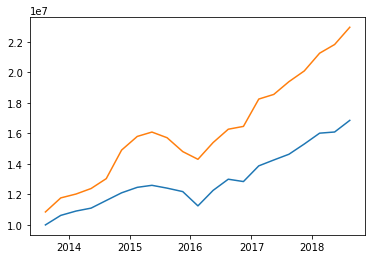

In [157]:
plt.plot(s_and_p_results)
plt.plot(strat_results)
plt.show